In [1]:
%load_ext autoreload
%load_ext tensorboard
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import os
import random
import yaml
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns
from importlib import reload
from pathlib import Path
import sklearn
import joblib
import torch
import pandas as pd
import copy
import cem

In [3]:
CUB_DIR = "/homes/me466/data/CUB200/"
CUB_IMAGE_DIR = os.path.join(CUB_DIR, "CUB_200_2011/images/")
CUB_IMAGE_PATH_FILE = os.path.join(CUB_DIR, "CUB_200_2011/images.txt")

with open(CUB_IMAGE_PATH_FILE, 'r') as f:
    cub_image_paths = [x.rstrip().split(" ")[-1] for x in f]
print("Found a total of", len(cub_image_paths), "CUB images")

Found a total of 11788 CUB images


In [4]:
################################################################################
## Global Variables Defining Experiment Flow
################################################################################

GPU = 1
NUM_WORKERS = 8
rc('text', usetex=False)
plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "serif"

In [5]:
import cem.data.CUB200.cub_loader as cub_data_module
result_dir = "/anfs/bigdisc/me466/mixcem_results/cub_incomplete/"
model_name = 'IntCEM_emb_size_16_intervention_weight_0.1_intervention_task_discount_1.1_Baseline_cwl_1'
# model_name = 'SeparatorCEM_concat_distance_emb_16_n_vars_1_ood_0_spl_1_warm_0_ibv_5_bt_50_blw_0_mlw_0_tip_0.25_itd_1.1_iw_0.1_cwl_1'
# model_name = 'SeparatorCEM_concat_distance_softmax_pd_16_emb_16_n_vars_1_ood_0_spl_0.1_warm_0_ibv_1_bt_1_blw_10_mlw_0_tip_0.25_itd_1.1_iw_0.1_cwl_1'
experiment_config = joblib.load(os.path.join(result_dir, f"{model_name}_experiment_config.joblib"))
dataset_config = experiment_config['dataset_config']
train_dl, val_dl, test_dl, imbalance, (n_concepts, n_tasks, concept_map) = \
    cub_data_module.generate_data(
        config=dataset_config,
        seed=42,
        output_dataset_vars=True,
        root_dir=dataset_config.get('root_dir', None),
    )

Global seed set to 42


		Selected concepts: [0, 1, 2, 3, 37, 38, 39, 40, 41, 42, 43, 44, 51, 52, 76, 77, 86, 87, 88, 99, 100, 101]
		Updated concept group map (with 7 groups):
			has_bill_shape -> [0, 1, 2, 3]
			has_head_pattern -> [4, 5]
			has_breast_color -> [6, 7, 8, 9, 10, 11]
			has_bill_length -> [12, 13]
			has_wing_shape -> [14, 15]
			has_tail_pattern -> [16, 17, 18]
			has_bill_color -> [19, 20, 21]


In [6]:
from experiments.run_experiments import _apply_transformation

ood_test_dl = _apply_transformation(
    test_dl,
    transformation_config=dict(
        name="random_noise",
        low_noise_level=1,
        noise_level=0.5,
    ),
)

In [7]:
import cem.utils.data as data_utils
fast_test_loader = torch.utils.data.DataLoader(
    test_dl.dataset,
    batch_size=data_utils._largest_divisor(len(test_dl.dataset), max_val=512),
    num_workers=4,
    shuffle=False,
)

fast_ood_test_loader = torch.utils.data.DataLoader(
    ood_test_dl.dataset,
    batch_size=data_utils._largest_divisor(len(ood_test_dl.dataset), max_val=512),
    num_workers=4,
    shuffle=False,
)

In [8]:
# Load the model
from cem.models.construction import load_trained_model

intcem = load_trained_model(
    config=experiment_config,
    n_tasks=experiment_config['n_tasks'],
    n_concepts=experiment_config['n_concepts'],
    result_dir=experiment_config['result_dir'],
    split=0,
    imbalance=imbalance,
    task_class_weights=None,
    intervene=False,
    train_dl=train_dl,
    output_latent=False,
    output_interventions=False,
)

In [9]:
# Generate embeddings for both test sets
import pytorch_lightning as pl
intcem.output_embeddings = True

prediction_trainer = pl.Trainer(
    accelerator='auto',
    devices='auto',
    logger=False,
)

test_batch_embs = prediction_trainer.predict(
    intcem,
    fast_test_loader,
)
pos_embeddings = torch.concat(
    [x[-2] for x in test_batch_embs],
    dim=0,
)
neg_embeddings = torch.concat(
    [x[-1] for x in test_batch_embs],
    dim=0,
)
test_bottlenecks = torch.concat(
    [x[1] for x in test_batch_embs],
    dim=0,
).detach().cpu().numpy()
test_embs = torch.concat(
    [pos_embeddings, neg_embeddings],
    dim=-1,
).detach().cpu().numpy()

test_probs = torch.concat(
    [x[0] for x in test_batch_embs],
    dim=0,
).detach().cpu().numpy()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [10]:
# Generate embeddings for both test sets
ood_test_batch_embs = prediction_trainer.predict(
    intcem,
    fast_ood_test_loader,
)
ood_pos_embeddings = torch.concat(
    [x[-2] for x in ood_test_batch_embs],
    dim=0,
)
ood_neg_embeddings = torch.concat(
    [x[-1] for x in ood_test_batch_embs],
    dim=0,
)
ood_test_bottlenecks = torch.concat(
    [x[1] for x in ood_test_batch_embs],
    dim=0,
).detach().cpu().numpy()
ood_test_embs = torch.concat(
    [ood_pos_embeddings, ood_neg_embeddings],
    dim=-1,
).detach().cpu().numpy()

ood_test_probs = torch.concat(
    [x[0] for x in ood_test_batch_embs],
    dim=0,
).detach().cpu().numpy()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [11]:
ood_test_bottlenecks = ood_test_bottlenecks.reshape((ood_test_bottlenecks.shape[0], experiment_config['n_concepts'], experiment_config['emb_size']))
test_bottlenecks = test_bottlenecks.reshape((test_bottlenecks.shape[0], experiment_config['n_concepts'], experiment_config['emb_size']))

In [12]:
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.manifold import TSNE

def plot_tsne_embeddings(
    test_c_embs,
    c_test,
    color_activations=None,
    color_activation_labels=None,
    attributes=None,
    perplexity=50,
    n_iter=1000,
    figsize=(8, 6),
    selected_concepts=None,
    y_test=None,
    model_name="SplitEmb",
    markers=None,
):
    results = []
    selected_concepts = selected_concepts or list(range(test_c_embs.shape[1]))
    for selected_concept in selected_concepts:
        if attributes is not None:
            print(
                "Selected concept at index",
                selected_concept,
                "with semantics",
                attributes[selected_concept],
            )
            
        tsne = TSNE(
            n_components=2,
            verbose=1,
            perplexity=perplexity,
            n_iter=n_iter,
            init='pca',
            learning_rate='auto',
        )
        tsne_results = tsne.fit_transform(test_c_embs[:, selected_concept, :])
        results.append(tsne_results)
        if y_test is not None:
            fig, ax = plt.subplots(
                1,
                1,
                figsize=figsize,
            )
            if attributes is not None:
                ax.set_title(
                    f"TSNE Embeddings for {attributes[selected_concept]} (by class)",
                    fontsize=15,
                )
            ax.scatter(
                tsne_results[:, 0],
                tsne_results[:, 1],
                c=y_test,
                s=5,
                cmap='ocean',
                marker='.',
            )
            ax.grid(False)
            ax.axis(False)
            plt.show()
            
        if color_activations is not None:
            activations = color_activations
        else:
            activations = [c_test[:, selected_concept]]
        for i, activation in enumerate(activations):
            if color_activation_labels is not None:
                activation_label = color_activation_labels[i]
            elif (color_activations is None):
                if (attributes is not None):
                    activation_label = attributes[selected_concept]
                else:
                    activation_label = f"Concept {selected_concept + 1}"
            else:
                activation_label = f"Concept {i + 1}"
            
            mask = activation == 1
            neg_mask = np.logical_not(mask)

            # And let's plot all of these
            fig, ax = plt.subplots(
                1,
                1,
                figsize=figsize,
            )
            if attributes is not None:
                ax.set_title(
                    f"{model_name} TSNE Embeddings for {attributes[selected_concept]}",
                    fontsize=15,
                )
            ax.scatter(
                tsne_results[mask, 0],
                tsne_results[mask, 1],
                color='red',
                label=activation_label + " active",
                s=5,
            )

            ax.scatter(
                tsne_results[neg_mask, 0],
                tsne_results[neg_mask, 1],
                color='blue',
                label=activation_label + " not active",
                s=5,
            )
            ax.grid(False)
            ax.axis(False)
            fig.legend(fontsize=10) #, loc='center right')
            plt.show()
        
    return results

In [13]:
_, y_test, c_test = data_utils.daloader_to_memory(
    test_dl,
    as_torch=False,
)
_, y_ood_test, c_ood_test = data_utils.daloader_to_memory(
    ood_test_dl,
    as_torch=False,
)

In [14]:
ground_truth_test_embs = np.zeros_like(test_bottlenecks)
test_mask = c_test == 1
ground_truth_test_embs[test_mask, :] = pos_embeddings[test_mask, :]
ground_truth_test_embs[~test_mask, :] = neg_embeddings[~test_mask, :]

ground_truth_ood_test_embs = np.zeros_like(ood_test_bottlenecks)
ood_test_mask = c_ood_test == 1
ground_truth_ood_test_embs[ood_test_mask, :] = ood_pos_embeddings[ood_test_mask, :]
ground_truth_ood_test_embs[~ood_test_mask, :] = ood_neg_embeddings[~ood_test_mask, :]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 11588 samples in 0.000s...
[t-SNE] Computed neighbors for 11588 samples in 3.331s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11588
[t-SNE] Computed conditional probabilities for sample 2000 / 11588
[t-SNE] Computed conditional probabilities for sample 3000 / 11588
[t-SNE] Computed conditional probabilities for sample 4000 / 11588
[t-SNE] Computed conditional probabilities for sample 5000 / 11588
[t-SNE] Computed conditional probabilities for sample 6000 / 11588
[t-SNE] Computed conditional probabilities for sample 7000 / 11588
[t-SNE] Computed conditional probabilities for sample 8000 / 11588
[t-SNE] Computed conditional probabilities for sample 9000 / 11588
[t-SNE] Computed conditional probabilities for sample 10000 / 11588
[t-SNE] Computed conditional probabilities for sample 11000 / 11588
[t-SNE] Computed conditional probabilities for sample 11588 / 11588
[t-SNE] Mean sigma: 0.648654


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.606606
[t-SNE] KL divergence after 1000 iterations: 1.467441


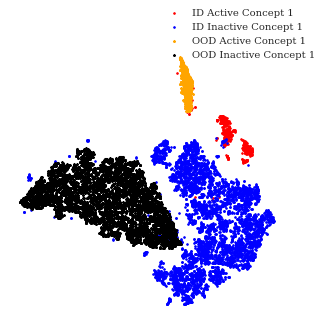

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 11588 samples in 0.000s...
[t-SNE] Computed neighbors for 11588 samples in 3.277s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11588
[t-SNE] Computed conditional probabilities for sample 2000 / 11588
[t-SNE] Computed conditional probabilities for sample 3000 / 11588
[t-SNE] Computed conditional probabilities for sample 4000 / 11588
[t-SNE] Computed conditional probabilities for sample 5000 / 11588
[t-SNE] Computed conditional probabilities for sample 6000 / 11588
[t-SNE] Computed conditional probabilities for sample 7000 / 11588
[t-SNE] Computed conditional probabilities for sample 8000 / 11588
[t-SNE] Computed conditional probabilities for sample 9000 / 11588
[t-SNE] Computed conditional probabilities for sample 10000 / 11588
[t-SNE] Computed conditional probabilities for sample 11000 / 11588
[t-SNE] Computed conditional probabilities for sample 11588 / 11588
[t-SNE] Mean sigma: 0.589408


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.122070
[t-SNE] KL divergence after 1000 iterations: 1.677466


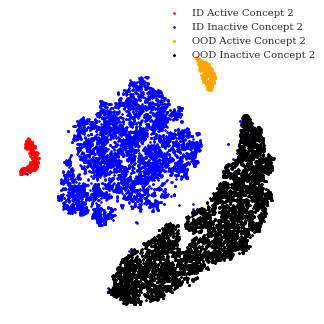

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 11588 samples in 0.000s...
[t-SNE] Computed neighbors for 11588 samples in 2.968s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11588
[t-SNE] Computed conditional probabilities for sample 2000 / 11588
[t-SNE] Computed conditional probabilities for sample 3000 / 11588
[t-SNE] Computed conditional probabilities for sample 4000 / 11588
[t-SNE] Computed conditional probabilities for sample 5000 / 11588
[t-SNE] Computed conditional probabilities for sample 6000 / 11588
[t-SNE] Computed conditional probabilities for sample 7000 / 11588
[t-SNE] Computed conditional probabilities for sample 8000 / 11588
[t-SNE] Computed conditional probabilities for sample 9000 / 11588
[t-SNE] Computed conditional probabilities for sample 10000 / 11588
[t-SNE] Computed conditional probabilities for sample 11000 / 11588
[t-SNE] Computed conditional probabilities for sample 11588 / 11588
[t-SNE] Mean sigma: 0.587697


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.268585
[t-SNE] KL divergence after 1000 iterations: 1.571638


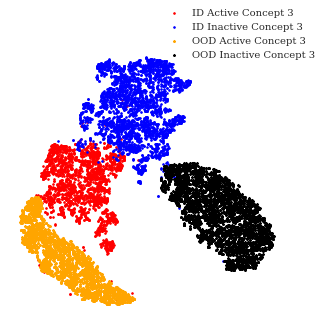

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 11588 samples in 0.000s...
[t-SNE] Computed neighbors for 11588 samples in 3.074s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11588
[t-SNE] Computed conditional probabilities for sample 2000 / 11588
[t-SNE] Computed conditional probabilities for sample 3000 / 11588
[t-SNE] Computed conditional probabilities for sample 4000 / 11588
[t-SNE] Computed conditional probabilities for sample 5000 / 11588
[t-SNE] Computed conditional probabilities for sample 6000 / 11588
[t-SNE] Computed conditional probabilities for sample 7000 / 11588
[t-SNE] Computed conditional probabilities for sample 8000 / 11588
[t-SNE] Computed conditional probabilities for sample 9000 / 11588
[t-SNE] Computed conditional probabilities for sample 10000 / 11588
[t-SNE] Computed conditional probabilities for sample 11000 / 11588
[t-SNE] Computed conditional probabilities for sample 11588 / 11588
[t-SNE] Mean sigma: 0.452922


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.890099
[t-SNE] KL divergence after 1000 iterations: 1.496411


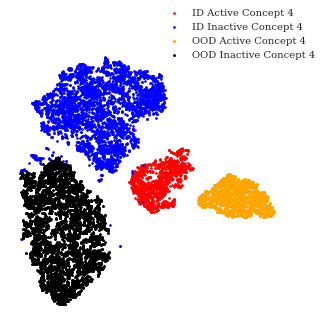

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 11588 samples in 0.000s...
[t-SNE] Computed neighbors for 11588 samples in 2.995s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11588
[t-SNE] Computed conditional probabilities for sample 2000 / 11588
[t-SNE] Computed conditional probabilities for sample 3000 / 11588
[t-SNE] Computed conditional probabilities for sample 4000 / 11588
[t-SNE] Computed conditional probabilities for sample 5000 / 11588
[t-SNE] Computed conditional probabilities for sample 6000 / 11588
[t-SNE] Computed conditional probabilities for sample 7000 / 11588
[t-SNE] Computed conditional probabilities for sample 8000 / 11588
[t-SNE] Computed conditional probabilities for sample 9000 / 11588
[t-SNE] Computed conditional probabilities for sample 10000 / 11588
[t-SNE] Computed conditional probabilities for sample 11000 / 11588
[t-SNE] Computed conditional probabilities for sample 11588 / 11588
[t-SNE] Mean sigma: 0.827009


/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.764656
[t-SNE] KL divergence after 1000 iterations: 1.782301


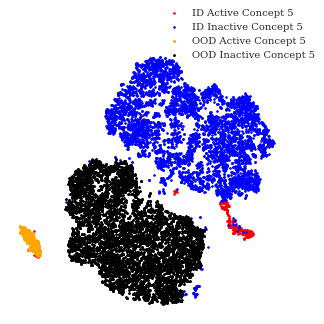

In [16]:
perplexity = 50
n_iter = 1000
figsize = (5, 5)

viz_concepts = 5 #experiment_config['n_concepts']

for selected_concept in range(viz_concepts):
    test_tsne = TSNE(
        n_components=2,
        verbose=1,
        perplexity=perplexity,
        n_iter=n_iter,
        init='pca',
        learning_rate='auto',
    )
    merged_dataset =  np.concatenate([ground_truth_test_embs[:, selected_concept, :], ground_truth_ood_test_embs[:, selected_concept, :]], axis=0)
    # merged_dataset =  ground_truth_test_embs[:, selected_concept, :]
    tsne_results = test_tsne.fit_transform(merged_dataset)

    # And let's plot all of these
    
    activation_label = f"Concept {selected_concept + 1}"
    mask = c_test[:, selected_concept] == 1
    neg_mask = np.logical_not(mask)

    fig, ax = plt.subplots(
        1,
        1,
        figsize=figsize,
    )
    ax.scatter(
        tsne_results[:c_test.shape[0], :][mask, 0],
        tsne_results[:c_test.shape[0], :][mask, 1],
        color='red',
        label=f"ID Active Concept {selected_concept + 1}",
        marker='.',
        s=10,
    )

    ax.scatter(
        tsne_results[:c_test.shape[0], :][neg_mask, 0],
        tsne_results[:c_test.shape[0], :][neg_mask, 1],
        color='blue',
        label=f"ID Inactive Concept {selected_concept + 1}",
        marker='.',
        s=10,
    )
    # ax.grid(False)
    # ax.axis(False)
    # fig.legend(fontsize=10) #, loc='center right')
    # plt.show()
    
    # merged_dataset =  ground_truth_ood_test_embs[:, selected_concept, :]
    # tsne_results = test_tsne.fit_transform(merged_dataset)
    # fig, ax = plt.subplots(
    #     1,
    #     1,
    #     figsize=figsize,
    # )
    mask = c_ood_test[:, selected_concept] == 1
    neg_mask = np.logical_not(mask)
    ax.scatter(
        tsne_results[c_test.shape[0]:, :][mask, 0],
        tsne_results[c_test.shape[0]:, :][mask, 1],
        # tsne_results[:, :][mask, 0],
        # tsne_results[:, :][mask, 1],
        color='orange',
        label=f"OOD Active Concept {selected_concept + 1}",
        marker='*',
        s=5,
    )

    ax.scatter(
        tsne_results[c_test.shape[0]:, :][neg_mask, 0],
        tsne_results[c_test.shape[0]:, :][neg_mask, 1],
        # tsne_results[:, :][neg_mask, 0],
        # tsne_results[:, :][neg_mask, 1],
        color='black',
        label=f"OOD Inactive Concept {selected_concept + 1}",
        marker='*',
        s=5,
    )

    ax.grid(False)
    ax.axis(False)
    fig.legend(fontsize=10) #, loc='center right')
    plt.show()

outside_z_score = 0.06644804970659303
outside_pdf = 0.0804280289955126


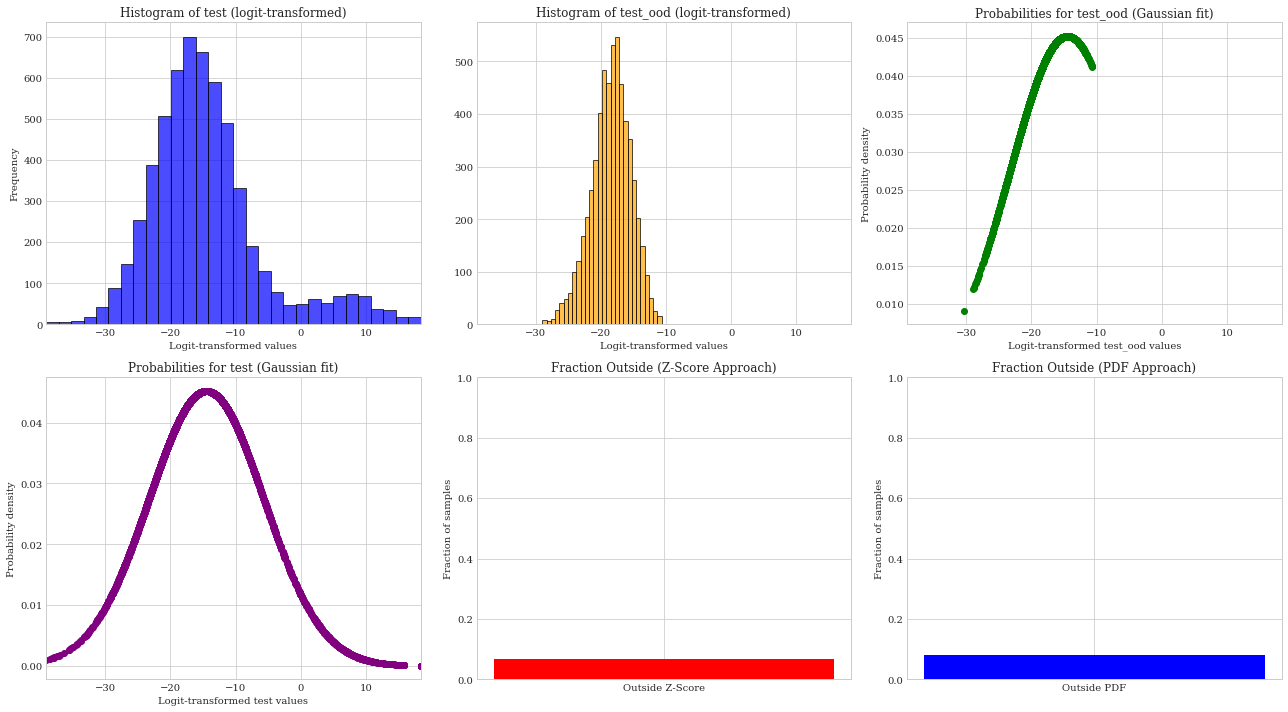

outside_z_score = 0.0
outside_pdf = 0.0


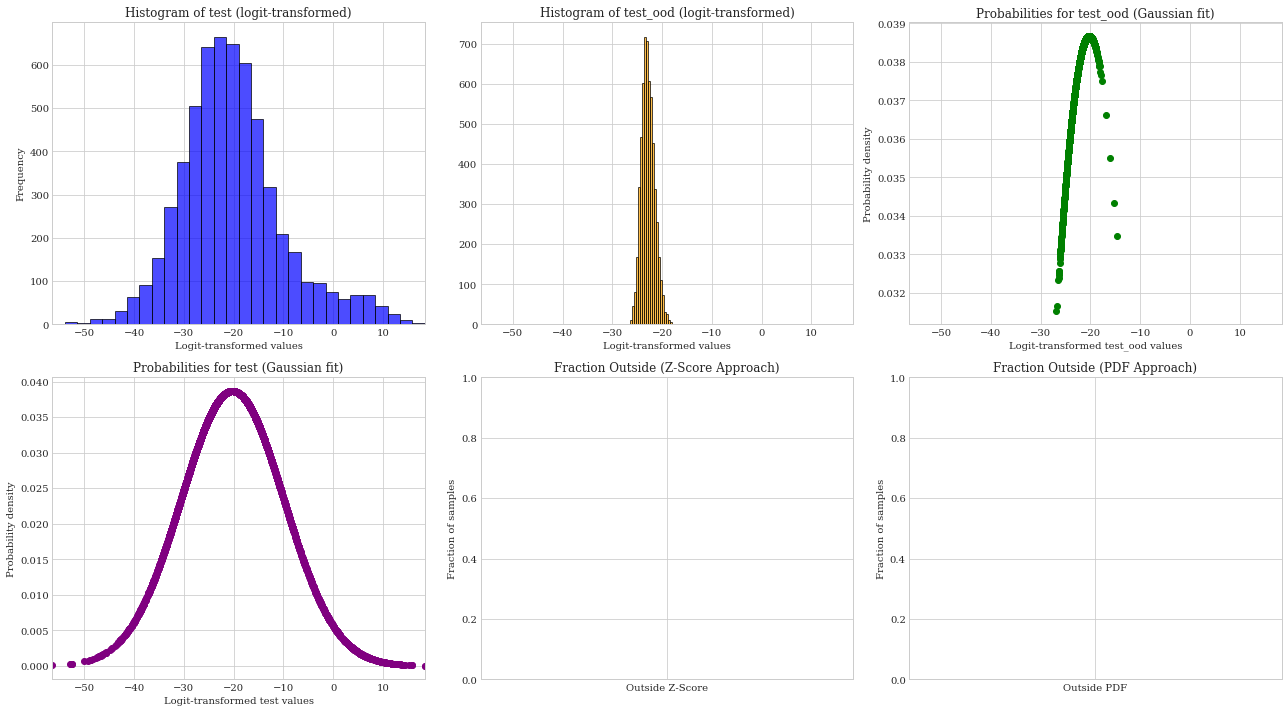

outside_z_score = 0.1898515705902658
outside_pdf = 0.025716258198136003


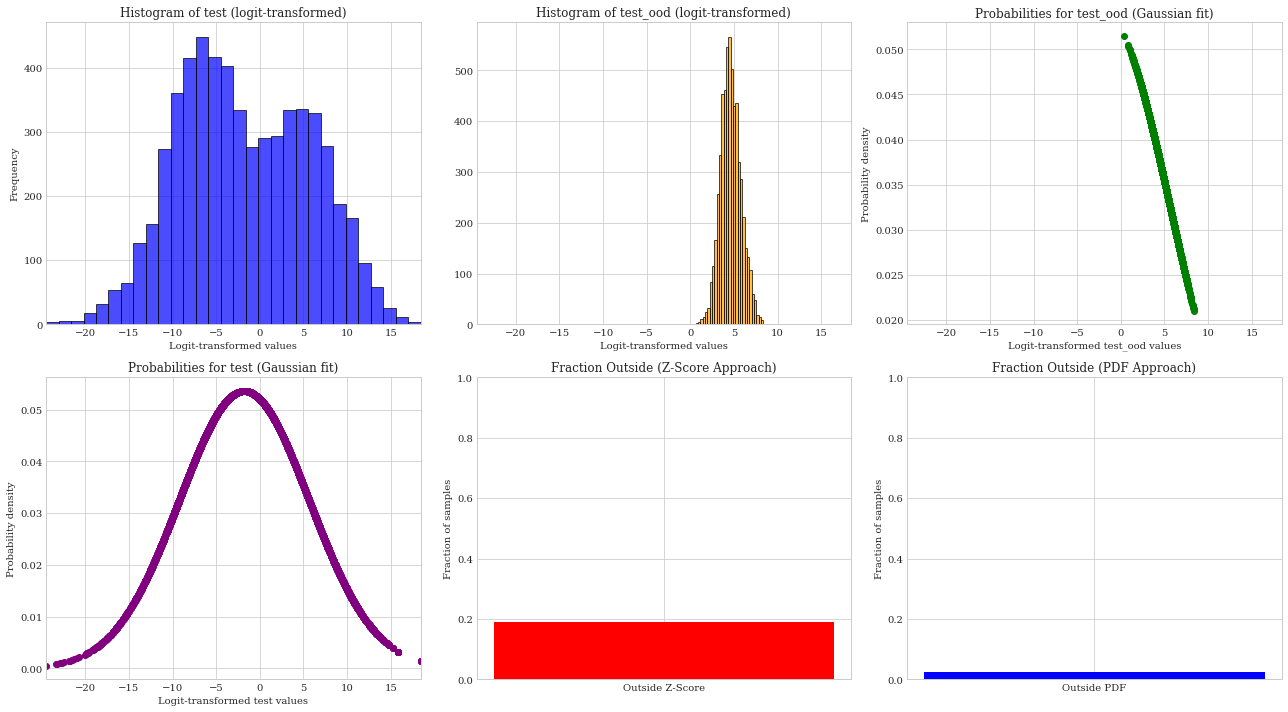

outside_z_score = 0.0
outside_pdf = 0.0


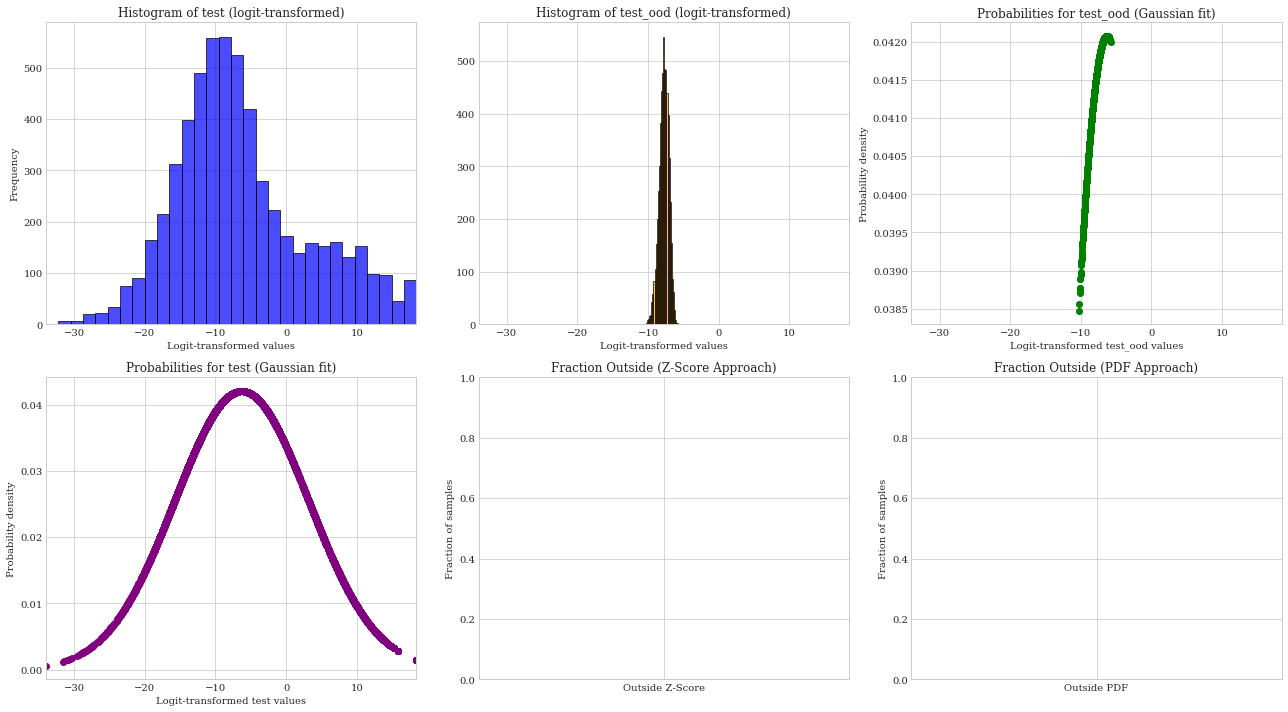

outside_z_score = 0.767863306869175
outside_pdf = 0.8831549879185364


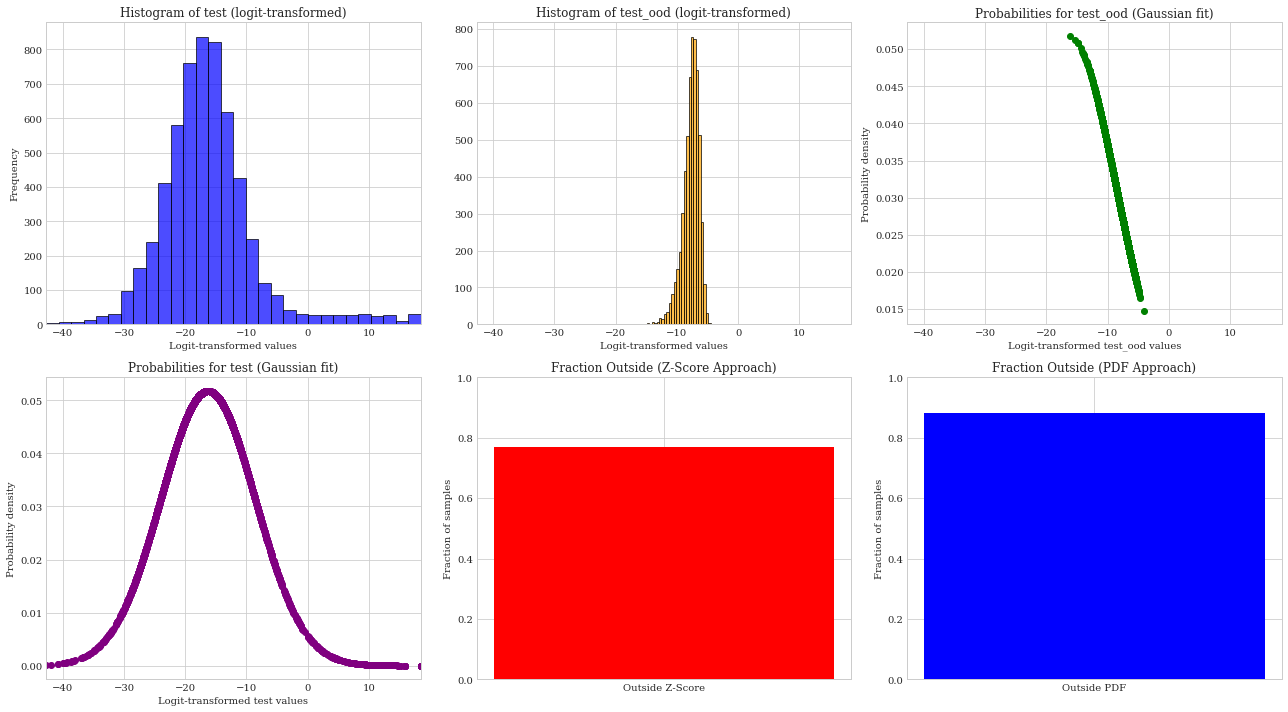

outside_z_score = 0.0005177770107007249
outside_pdf = 0.0


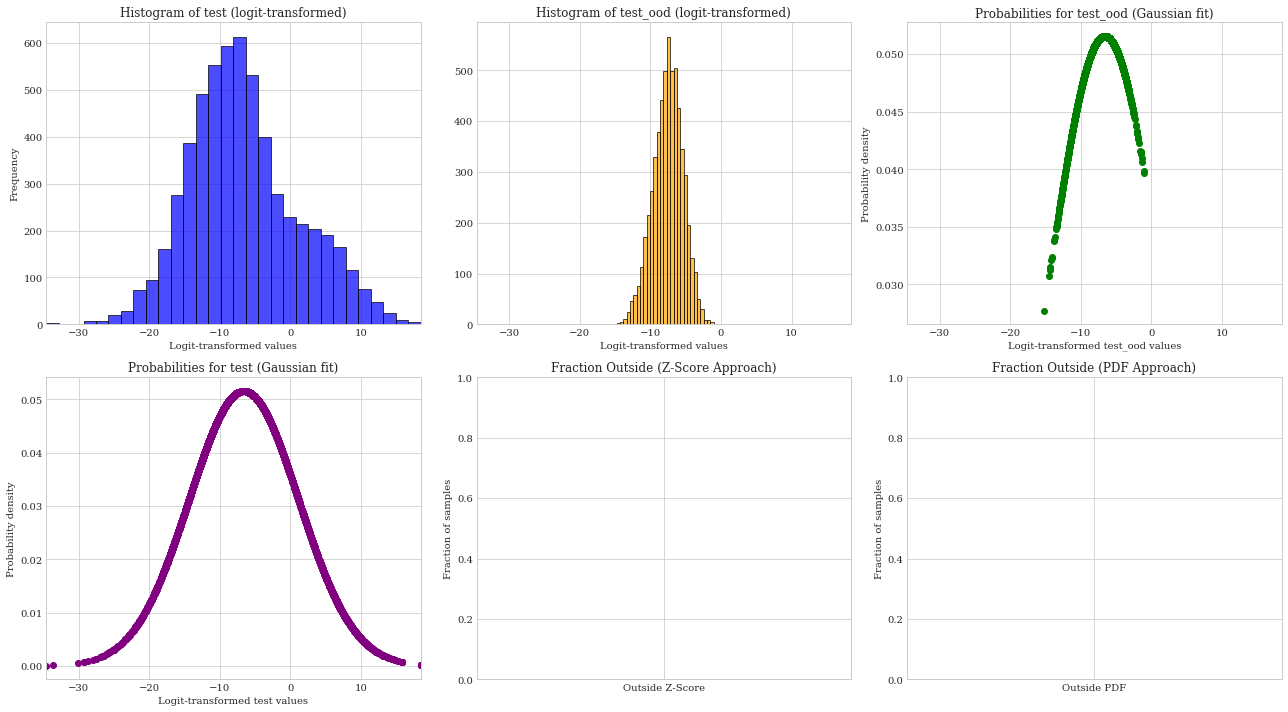

outside_z_score = 0.011045909561615464
outside_pdf = 0.02433551950293407


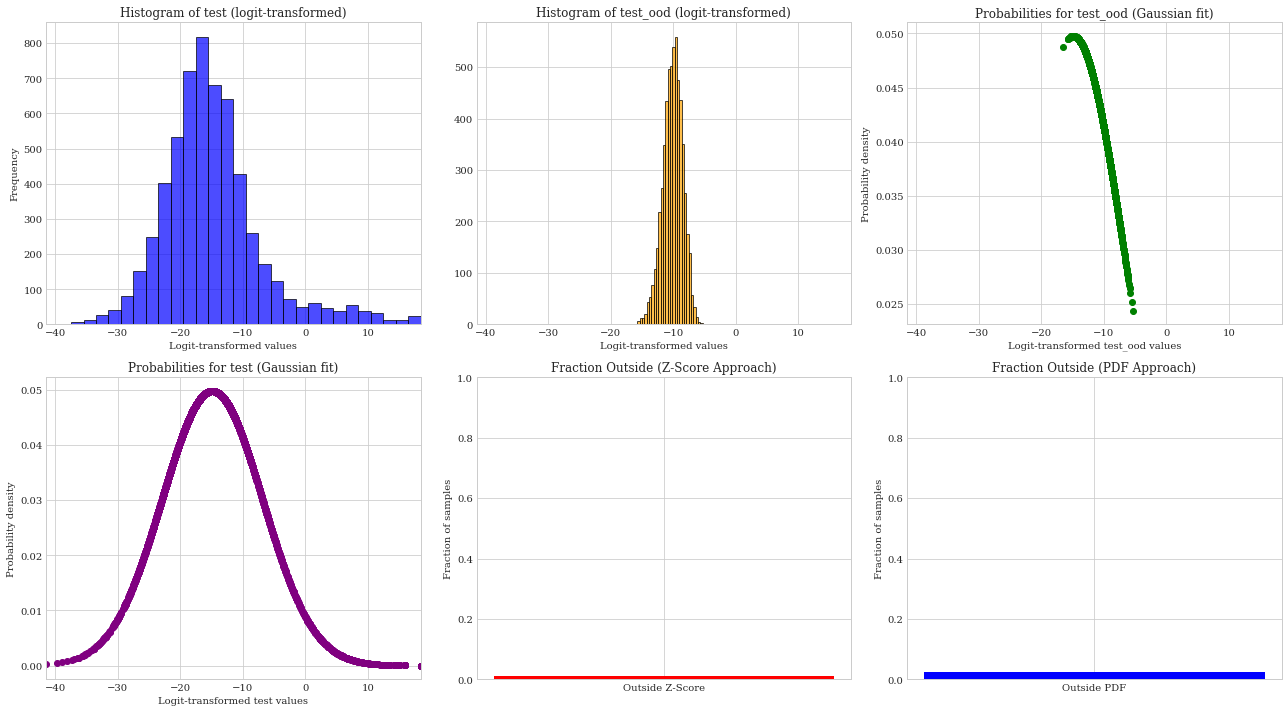

outside_z_score = 0.009837763203313773
outside_pdf = 0.0060407317915084574


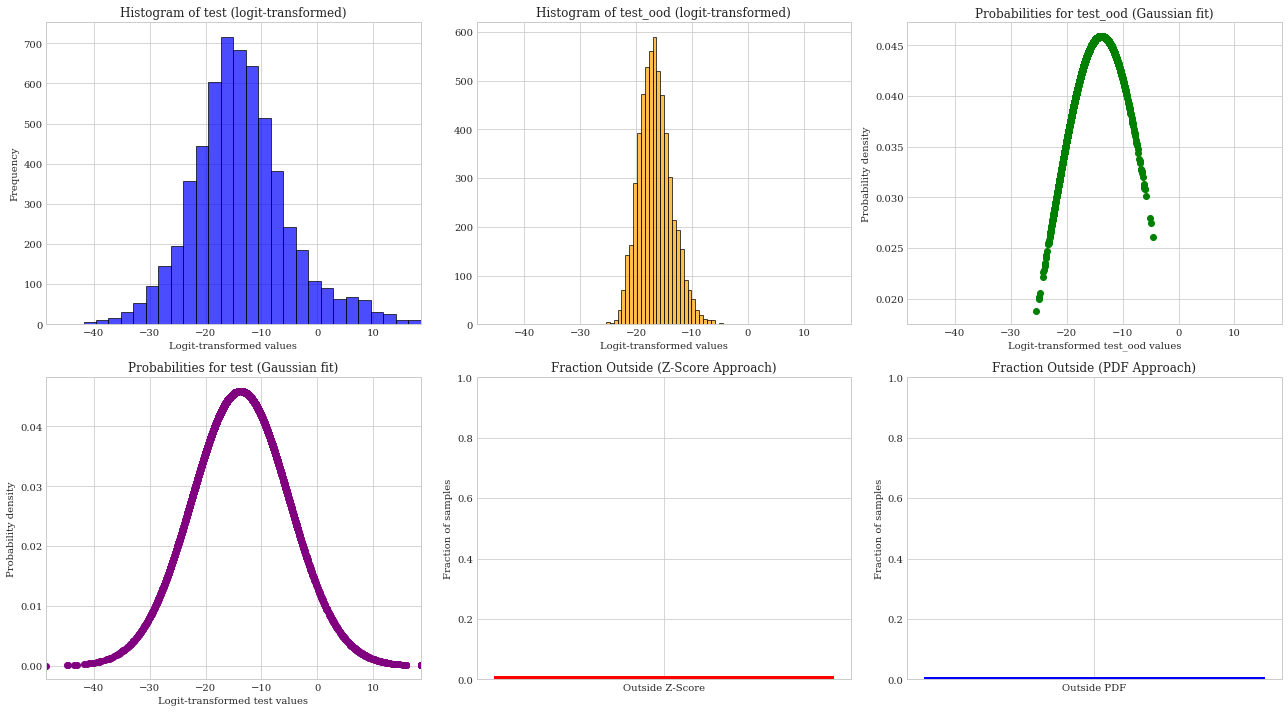

outside_z_score = 0.0
outside_pdf = 0.0


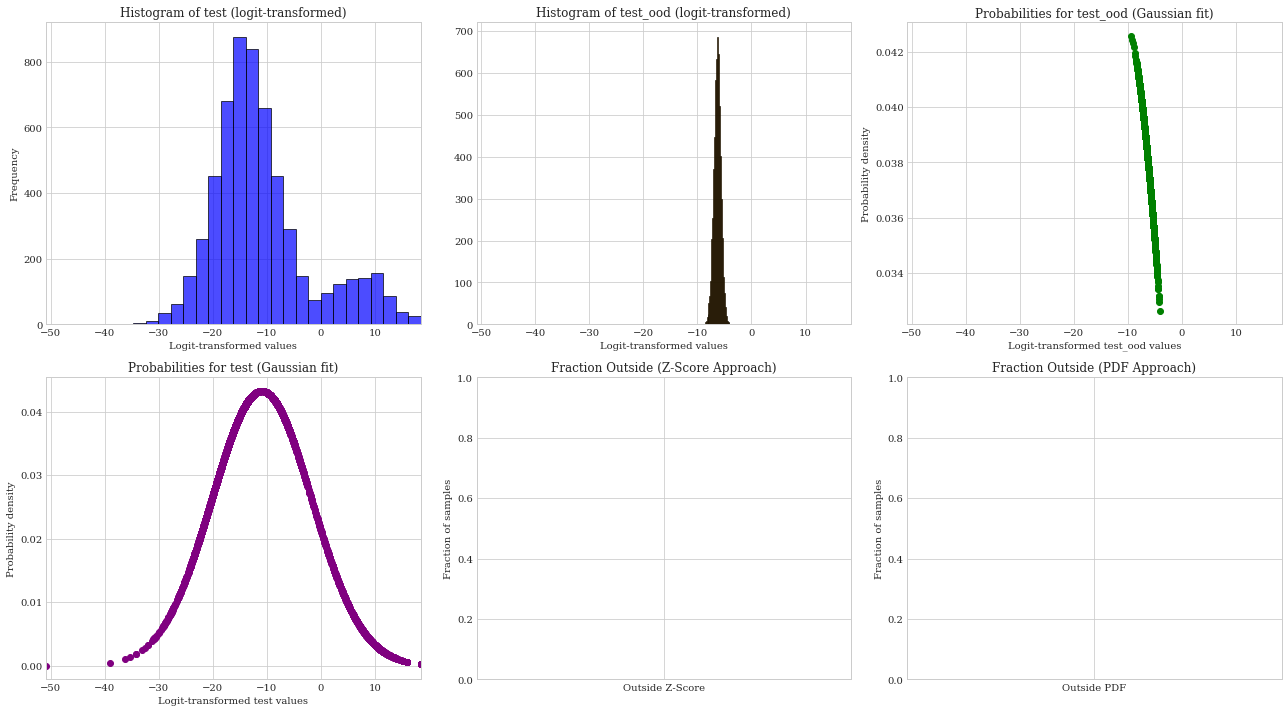

outside_z_score = 0.46237487055574733
outside_pdf = 0.1927856403175699


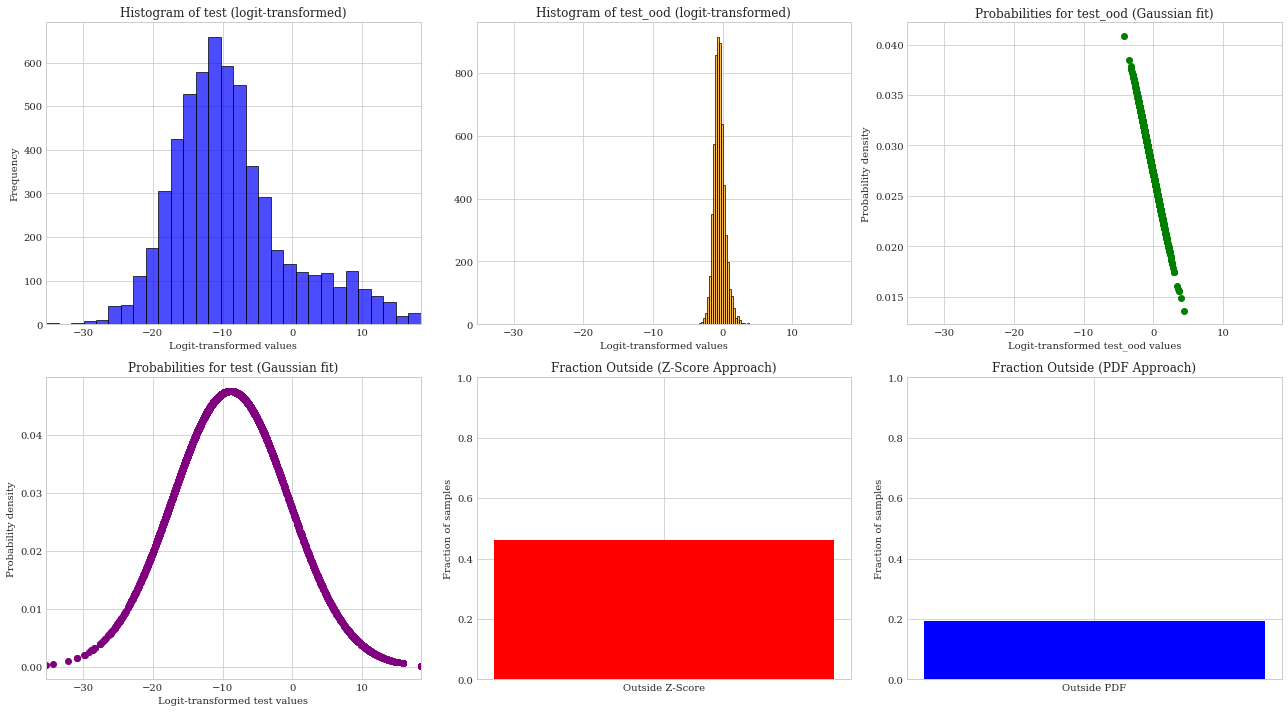

outside_z_score = 0.43217121159820504
outside_pdf = 0.23317224715222645


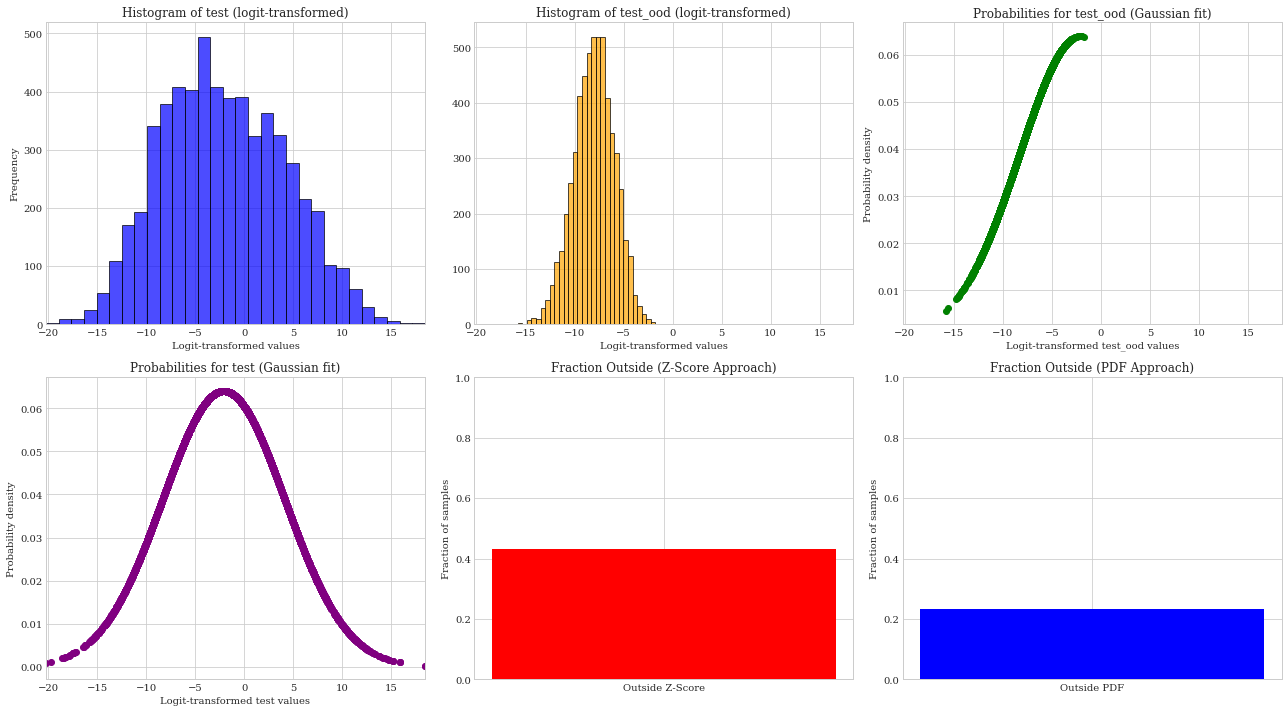

outside_z_score = 0.0
outside_pdf = 0.0


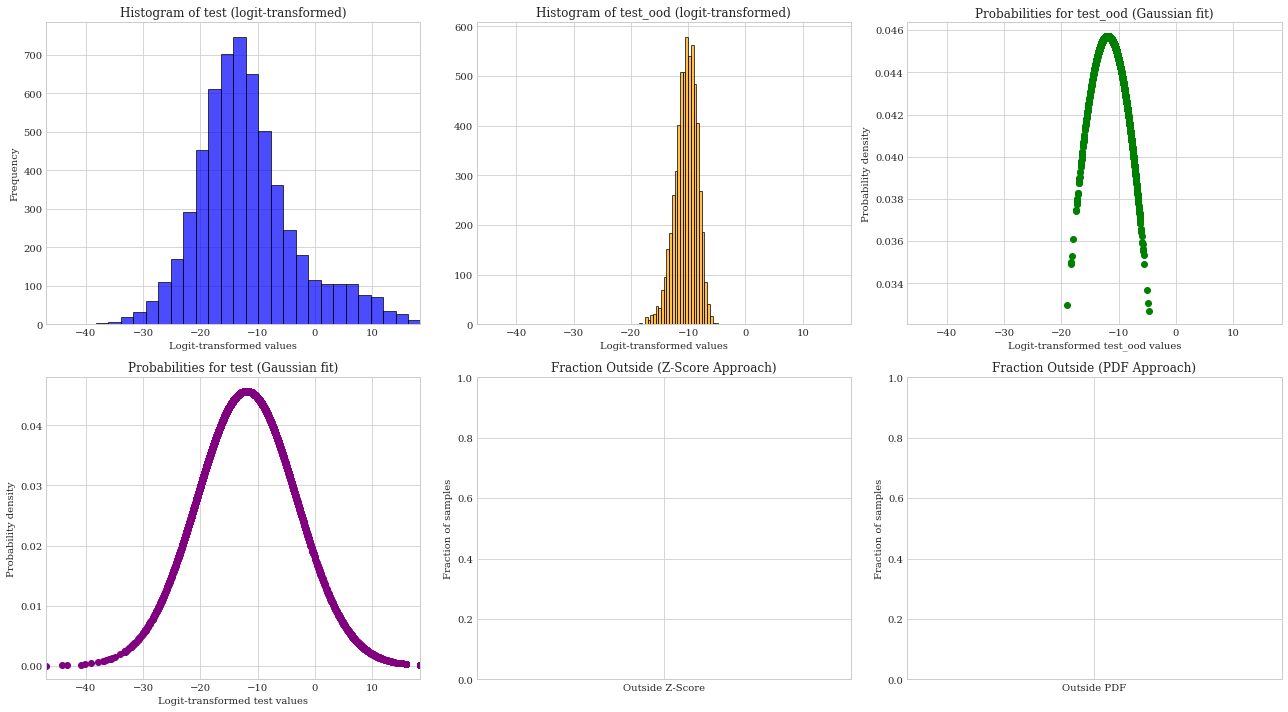

outside_z_score = 0.227131515360718
outside_pdf = 0.04004142216085606


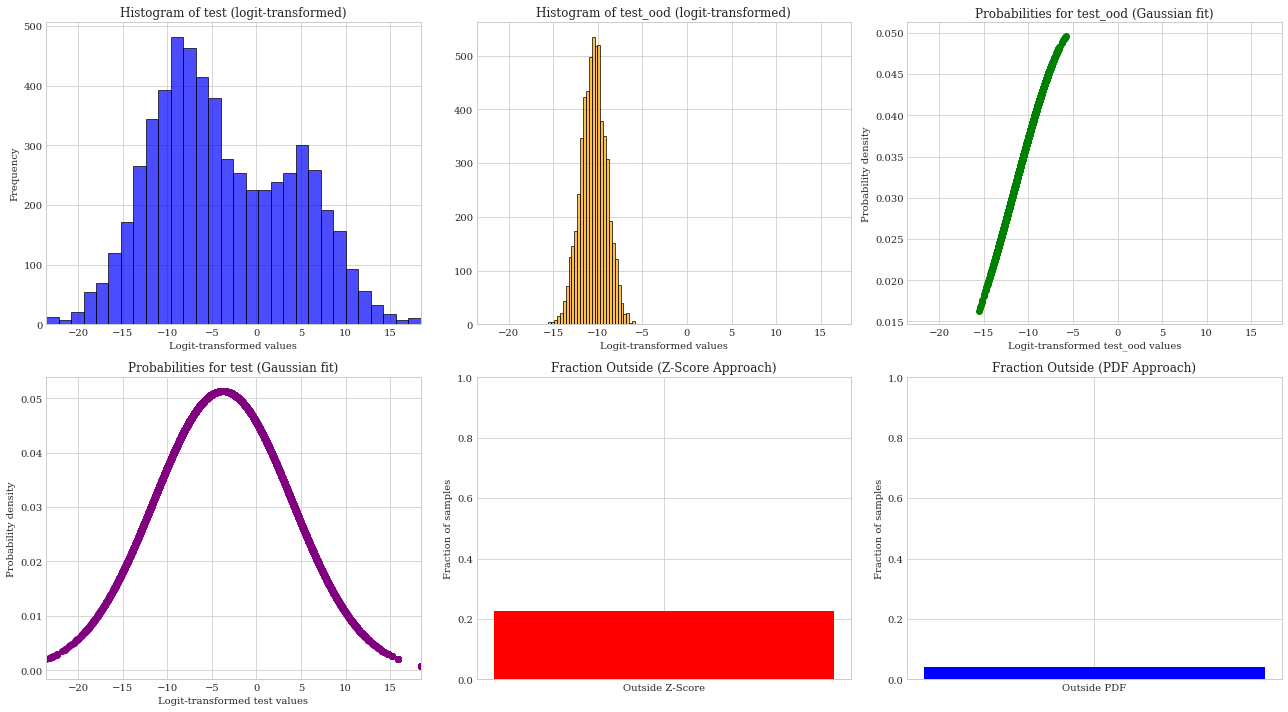

outside_z_score = 0.0
outside_pdf = 0.0


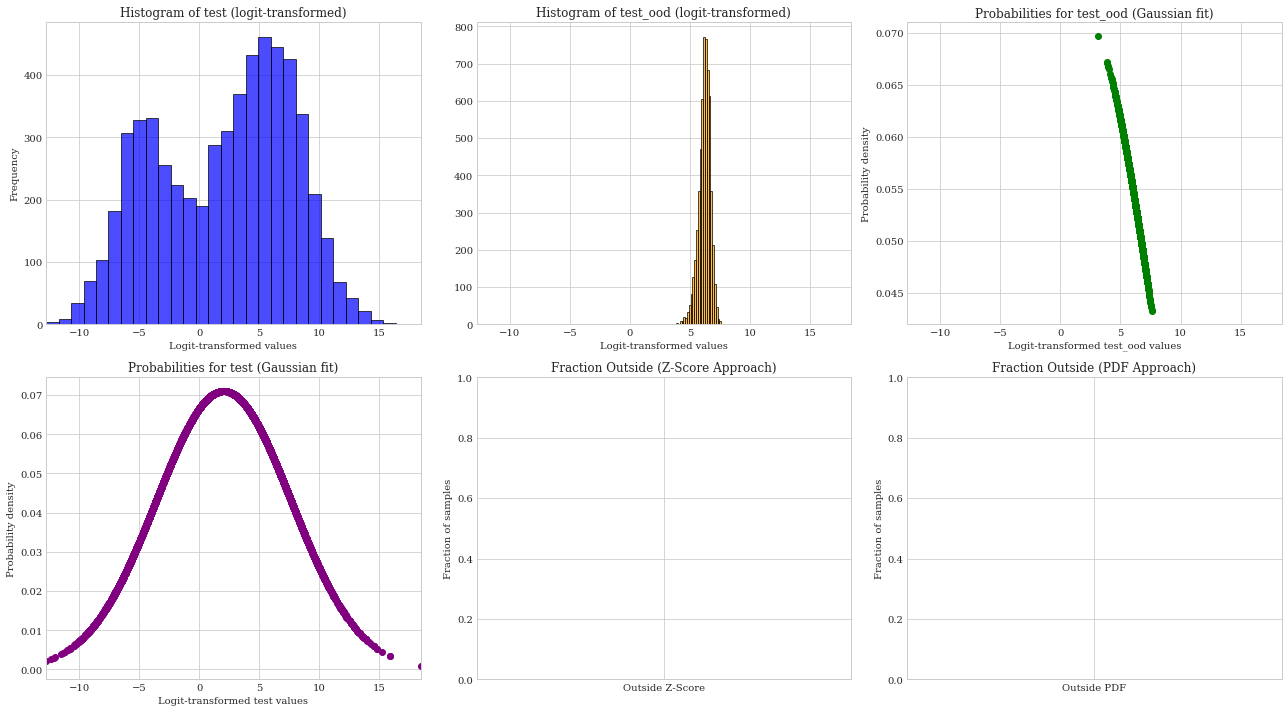

outside_z_score = 0.0
outside_pdf = 0.0


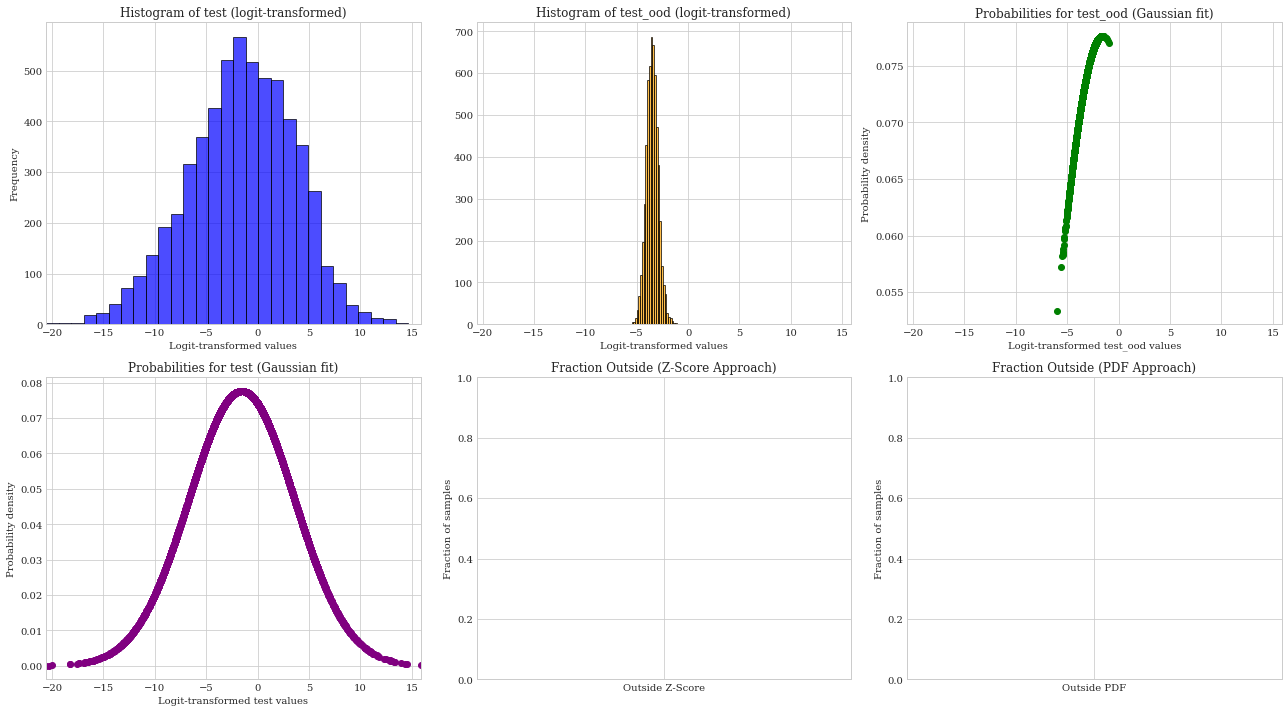

outside_z_score = 0.8270624784259579
outside_pdf = 0.7600966517086641


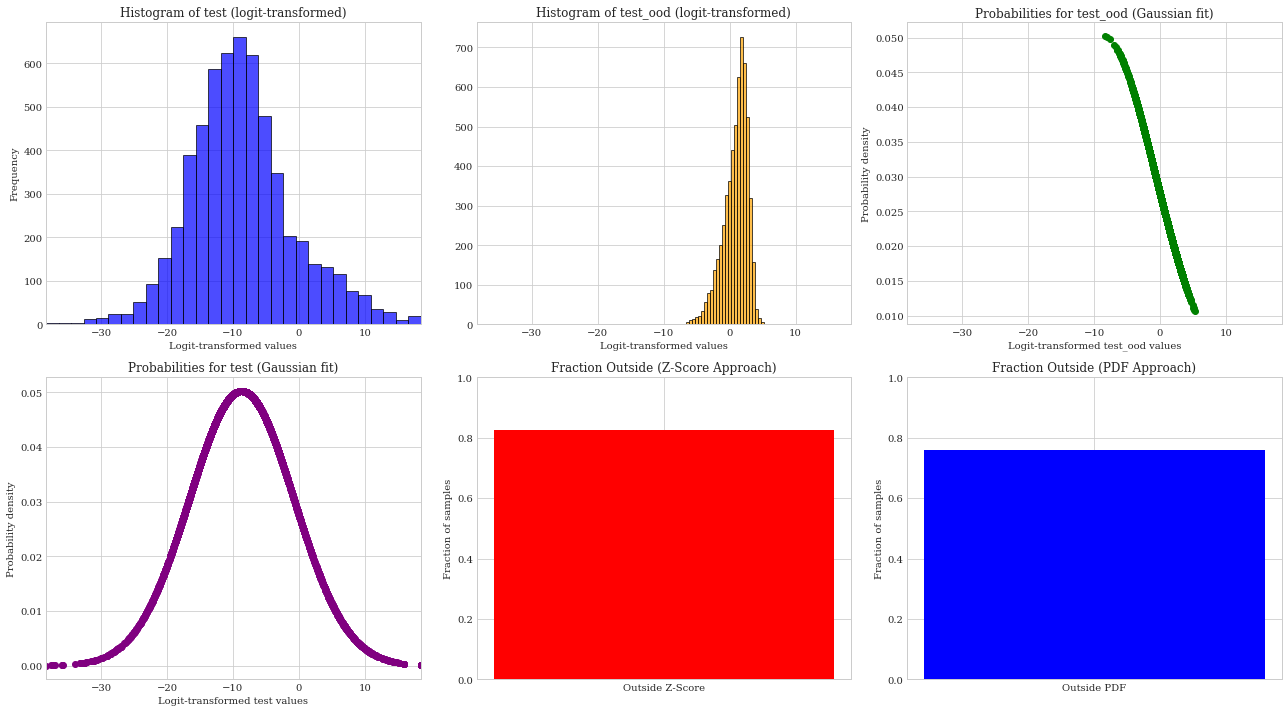

outside_z_score = 0.03382809803244736
outside_pdf = 0.0060407317915084574


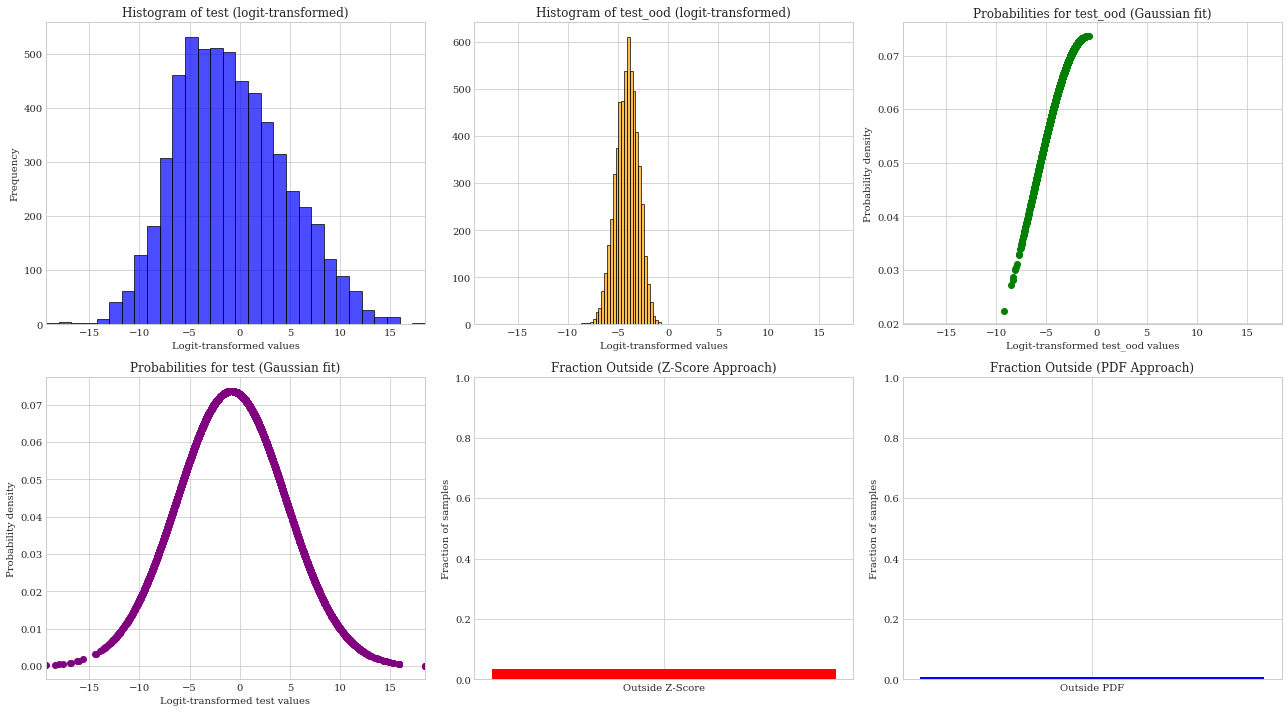

outside_z_score = 1.0
outside_pdf = 1.0


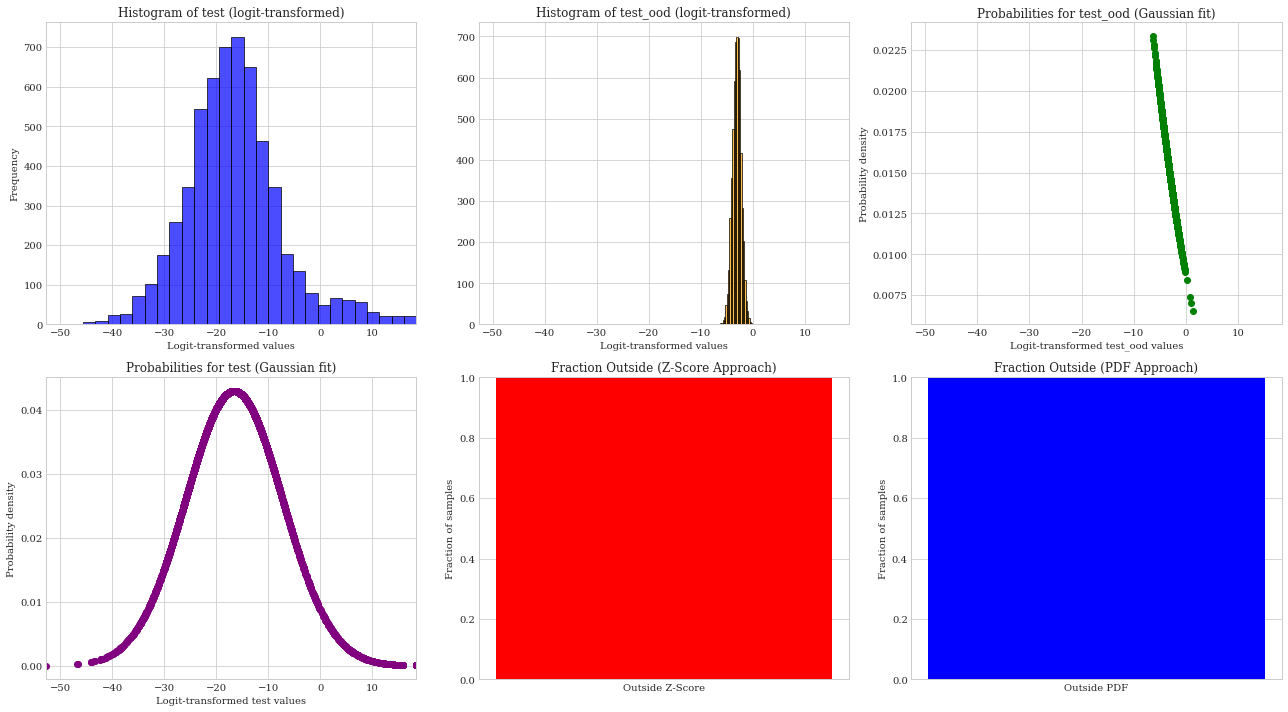

outside_z_score = 0.04452882292026234
outside_pdf = 0.03054884363134277


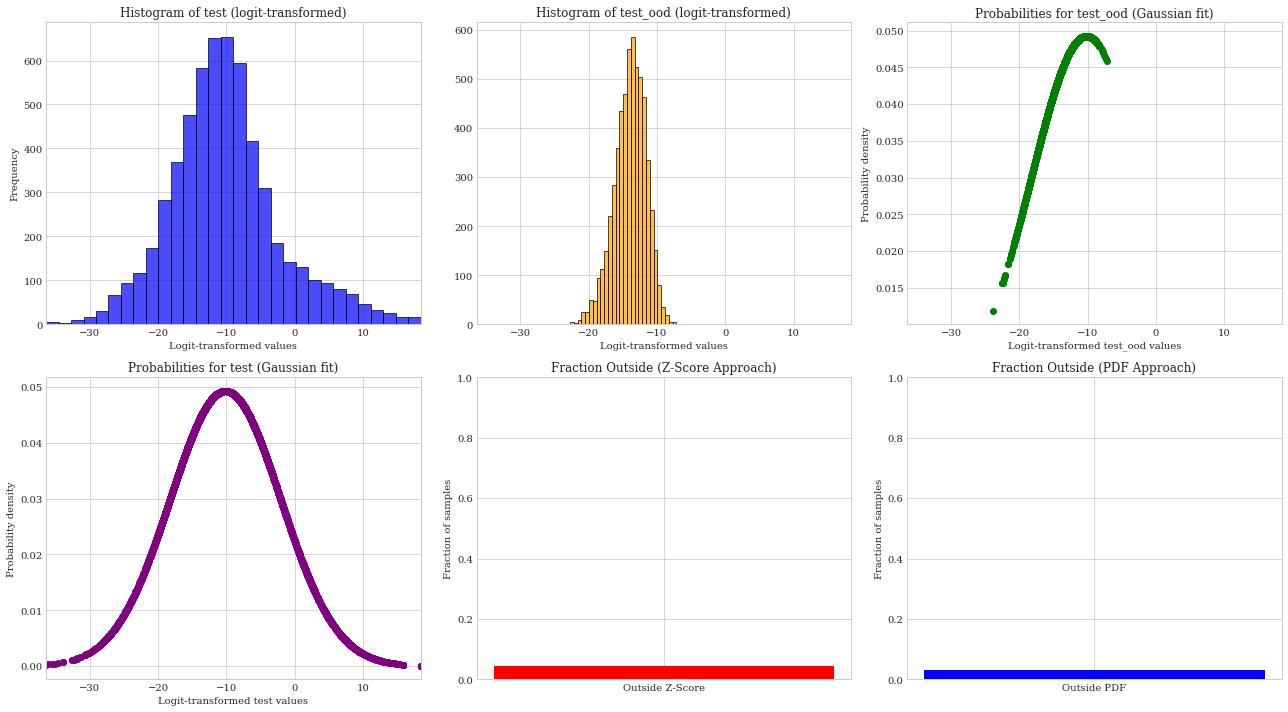

outside_z_score = 0.01794960303762513
outside_pdf = 0.01156368657231619


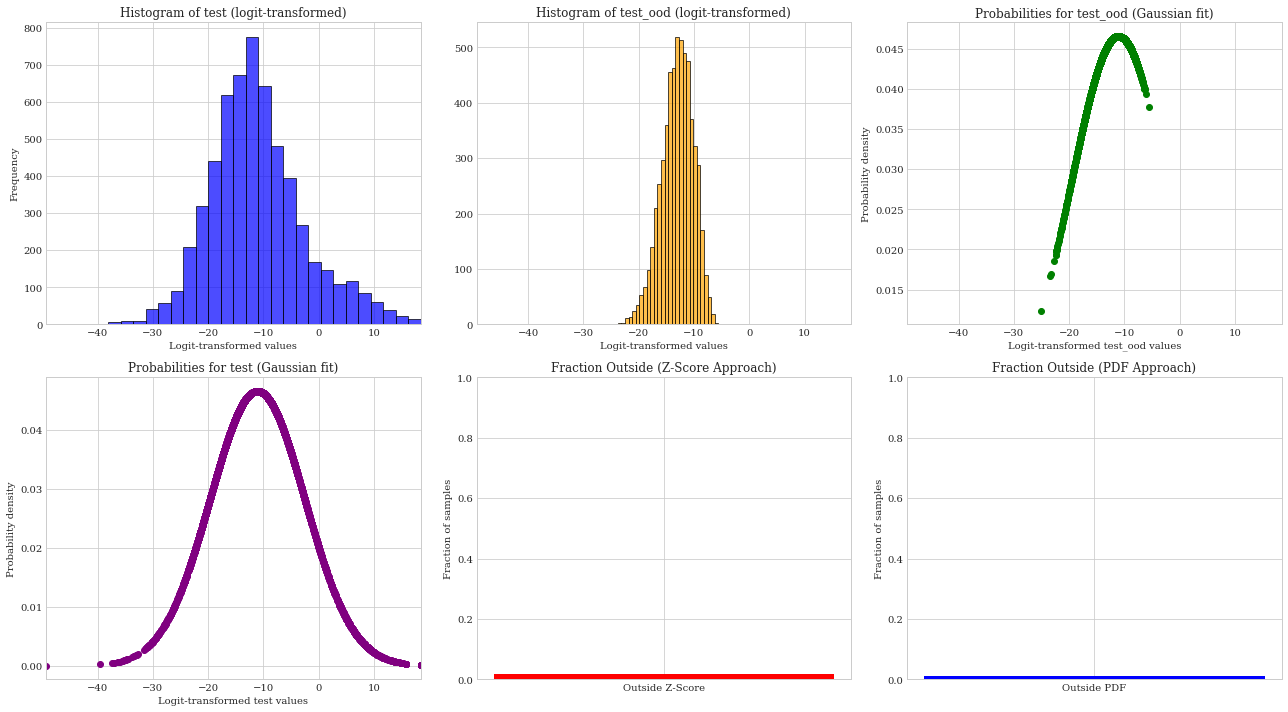

outside_z_score = 0.7254055919917156
outside_pdf = 0.49240593717638936


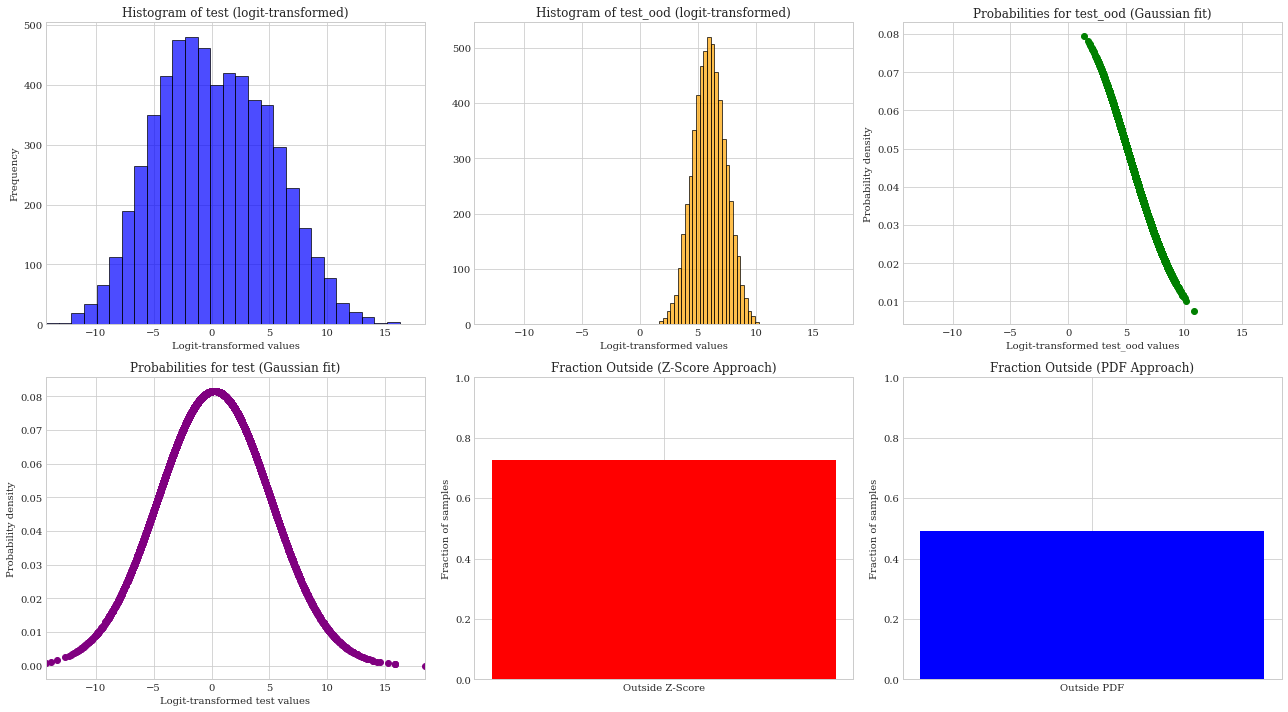

outside_z_score = 0.3027269589230238
outside_pdf = 0.30307214359682433


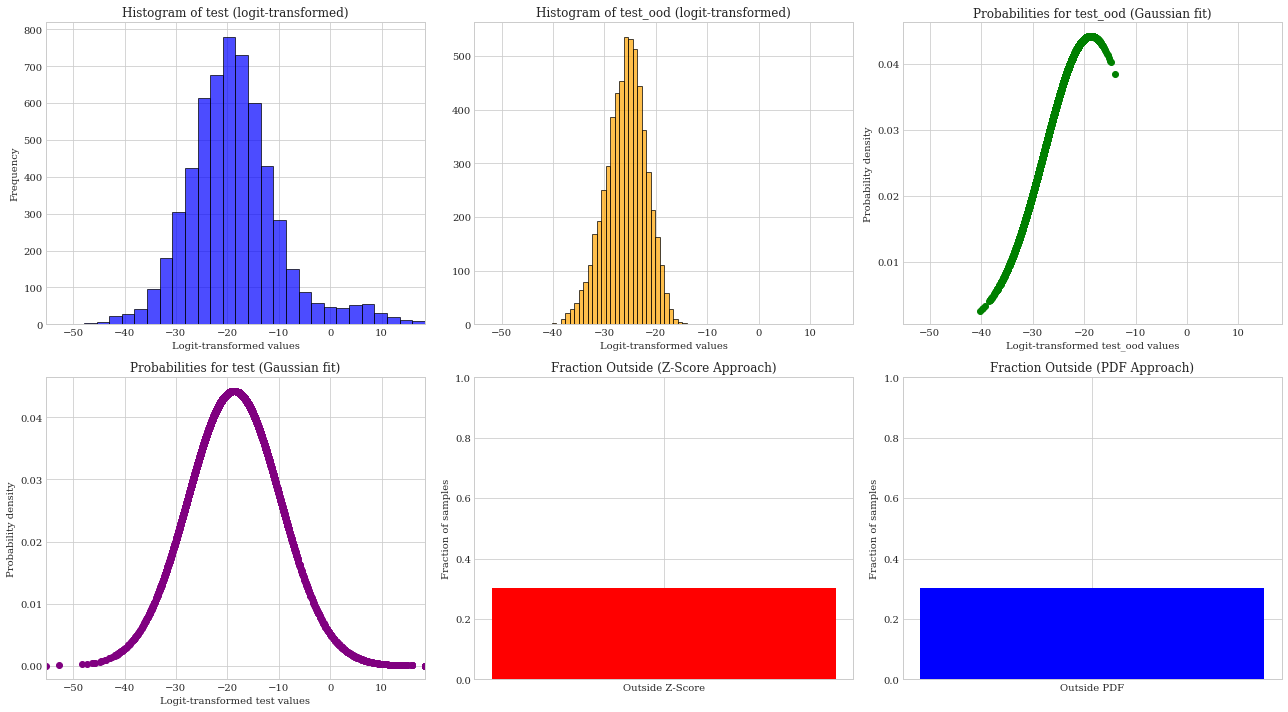

In [17]:
# Create a figure with two subplots side by side
from scipy.stats import norm

def logit(x):
    return np.log(x / (1 - x + 1e-8))

for concept_idx in range(ood_test_probs.shape[-1]):

    test_logit = logit(test_probs[:, concept_idx])
    test_ood_logit = logit(ood_test_probs[:, concept_idx])
    xmin = min(test_logit.min(), test_ood_logit.min())
    xmax = max(test_logit.max(), test_ood_logit.max())

    # Fit a Gaussian (normal) distribution to the logit-transformed 'test'
    mu, sigma = norm.fit(test_logit)

    # Calculate the PDF values of test_ood_logit under the fitted Gaussian distribution
    test_ood_prob = norm.pdf(test_ood_logit, mu, sigma)

    # Calculate the PDF values of test_logit under the fitted Gaussian distribution
    test_prob = norm.pdf(test_logit, mu, sigma)

    # Z-Score Approach: Compute z-scores for test_ood_logit
    z_scores = (test_ood_logit - mu) / sigma
    z_threshold = 1  # Common threshold for z-scores (2 standard deviations)

    # Probability Density Approach: Set a PDF threshold (5th percentile)
    pdf_threshold = np.percentile(norm.pdf(test_logit, mu, sigma), 25)

    # Determine fractions of samples falling outside based on z-score and PDF approaches
    outside_z_score = np.sum(np.abs(z_scores) > z_threshold) / len(test_ood_logit)
    print("outside_z_score =", outside_z_score)
    outside_pdf = np.sum(test_ood_prob < pdf_threshold) / len(test_ood_logit)
    print("outside_pdf =", outside_pdf)

    # Create a figure with six subplots: 
    # - First two for the histograms
    # - Third and fourth for the probabilities
    # - Fifth and sixth for the fraction of samples likely outside the distribution
    fig, ax = plt.subplots(2, 3, figsize=(18, 10), sharey=False)

    # Plot the histogram for 'test_logit'
    ax[0, 0].hist(test_logit, bins=30, color='blue', alpha=0.7, edgecolor='black')
    ax[0, 0].set_title('Histogram of test (logit-transformed)')
    ax[0, 0].set_xlabel('Logit-transformed values')
    ax[0, 0].set_ylabel('Frequency')
    ax[0, 0].set_xlim(xmin, xmax)  # Set the x-axis limits

    # Plot the histogram for 'test_ood_logit'
    ax[0, 1].hist(test_ood_logit, bins=30, color='orange', alpha=0.7, edgecolor='black')
    ax[0, 1].set_title('Histogram of test_ood (logit-transformed)')
    ax[0, 1].set_xlabel('Logit-transformed values')
    ax[0, 1].set_xlim(xmin, xmax)  # Set the x-axis limits

    # Plot the probabilities of test_ood_logit coming from the fitted Gaussian
    ax[0, 2].plot(test_ood_logit, test_ood_prob, 'o', color='green')
    ax[0, 2].set_title('Probabilities for test_ood (Gaussian fit)')
    ax[0, 2].set_xlabel('Logit-transformed test_ood values')
    ax[0, 2].set_ylabel('Probability density')
    ax[0, 2].set_xlim(xmin, xmax)  # Match the x-axis limits for comparison

    # Plot the probabilities of test_logit coming from the fitted Gaussian
    ax[1, 0].plot(test_logit, test_prob, 'o', color='purple')
    ax[1, 0].set_title('Probabilities for test (Gaussian fit)')
    ax[1, 0].set_xlabel('Logit-transformed test values')
    ax[1, 0].set_ylabel('Probability density')
    ax[1, 0].set_xlim(xmin, xmax)  # Match the x-axis limits for comparison

    # Plot the fraction of samples falling outside based on z-score
    ax[1, 1].bar(['Outside Z-Score'], [outside_z_score], color='red')
    ax[1, 1].set_title('Fraction Outside (Z-Score Approach)')
    ax[1, 1].set_ylim(0, 1)
    ax[1, 1].set_ylabel('Fraction of samples')

    # Plot the fraction of samples falling outside based on PDF threshold
    ax[1, 2].bar(['Outside PDF'], [outside_pdf], color='blue')
    ax[1, 2].set_title('Fraction Outside (PDF Approach)')
    ax[1, 2].set_ylim(0, 1)
    ax[1, 2].set_ylabel('Fraction of samples')

    # Ensure the layout is clean
    plt.tight_layout()

    # Show the plot
    plt.show()

/tmp/ipykernel_1893967/1434492086.py:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print("acc =", np.mean((log_reg.predict_proba(X) > 0.5) == c))
/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


acc = 0.0


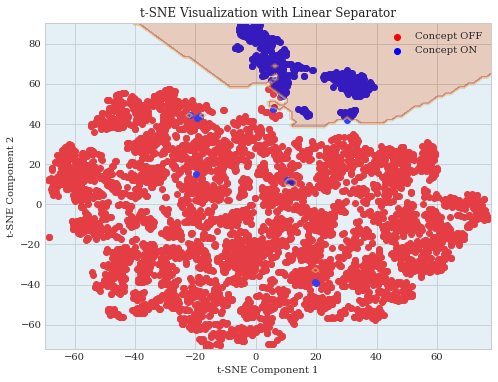

In [28]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

concept_idx = 0
c = c_test[:, concept_idx:concept_idx+1]

# Combine bottleneck and ood_bottleneck into one dataset
emb_size = test_embs.shape[-1]//2
X = ground_truth_test_embs[:, 0, :] #np.concatenate([test_embs[c[:, 0] == 0, concept_idx, emb_size:], test_embs[c[:, 0] == 1, concept_idx, :emb_size]], axis=0)
c = c[:, 0]

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 2: Fit a logistic regression model in the original high-dimensional space
log_reg = LogisticRegression()
log_reg.fit(X, c)  # c is the label array
print("acc =", np.mean((log_reg.predict_proba(X) > 0.5) == c))

# Step 3: Apply t-SNE to reduce dimensionality to 2D for visualization purposes
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Step 4: Plot the samples in t-SNE 2D space
plt.figure(figsize=(8, 6))

# Plot samples with label 0
plt.scatter(X_tsne[c == 0, 0], X_tsne[c == 0, 1], color='red', label='Concept OFF')

# Plot samples with label 1
plt.scatter(X_tsne[c == 1, 0], X_tsne[c == 1, 1], color='blue', label='Concept ON')

# Step 5: Create a meshgrid for plotting the decision boundary
x_min, x_max = X_tsne[:, 0].min() - 1, X_tsne[:, 0].max() + 1
y_min, y_max = X_tsne[:, 1].min() - 1, X_tsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Flatten the grid to pass through the model
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Step 6: Map the t-SNE grid back to the original space
# Since we can't inverse t-SNE, we'll approximate by using the nearest points in the original space
from scipy.spatial import KDTree

# Create a KDTree for the t-SNE points
tree = KDTree(X_tsne)

# Find the nearest high-dimensional points for each t-SNE grid point
_, indices = tree.query(grid_points)
X_grid_original_space = X[indices]

# Step 7: Predict using the logistic regression model trained on the original space
Z = log_reg.predict(X_grid_original_space)
Z = Z.reshape(xx.shape)

# Step 8: Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)

# Step 9: Set plot labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization with Linear Separator')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_1893967/2702481712.py:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print("acc =", np.mean((log_reg_ood.predict_proba(X_ood) > 0.5) == c))
/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


acc = 0.0


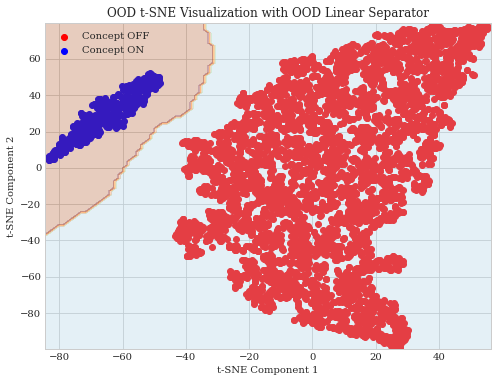

In [29]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

concept_idx = 0
c = c_ood_test[:, concept_idx:concept_idx+1]

# Combine bottleneck and ood_bottleneck into one dataset
emb_size = test_embs.shape[-1]//2
X_ood = ground_truth_ood_test_embs[:, 0, :] #np.concatenate([test_embs[c[:, 0] == 0, concept_idx, emb_size:], test_embs[c[:, 0] == 1, concept_idx, :emb_size]], axis=0)
c = c[:, 0]

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 2: Fit a logistic regression model in the original high-dimensional space
log_reg_ood = LogisticRegression()
log_reg_ood.fit(X_ood, c)  # c is the label array
print("acc =", np.mean((log_reg_ood.predict_proba(X_ood) > 0.5) == c))

# Step 3: Apply t-SNE to reduce dimensionality to 2D for visualization purposes
tsne_ood = TSNE(n_components=2, random_state=42)
X_ood_tsne = tsne_ood.fit_transform(X_ood)

# Step 4: Plot the samples in t-SNE 2D space
plt.figure(figsize=(8, 6))

# Plot samples with label 0
plt.scatter(X_ood_tsne[c == 0, 0], X_ood_tsne[c == 0, 1], color='red', label='Concept OFF')

# Plot samples with label 1
plt.scatter(X_ood_tsne[c == 1, 0], X_ood_tsne[c == 1, 1], color='blue', label='Concept ON')

# Step 5: Create a meshgrid for plotting the decision boundary
x_min, x_max = X_ood_tsne[:, 0].min() - 1, X_ood_tsne[:, 0].max() + 1
y_min, y_max = X_ood_tsne[:, 1].min() - 1, X_ood_tsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Flatten the grid to pass through the model
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Step 6: Map the t-SNE grid back to the original space
# Since we can't inverse t-SNE, we'll approximate by using the nearest points in the original space
from scipy.spatial import KDTree

# Create a KDTree for the t-SNE points
tree_ood = KDTree(X_ood_tsne)

# Find the nearest high-dimensional points for each t-SNE grid point
_, indices = tree_ood.query(grid_points)
X_grid_original_space = X_ood[indices]

# Step 7: Predict using the logistic regression model trained on the original space
Z = log_reg_ood.predict(X_grid_original_space)
Z = Z.reshape(xx.shape)

# Step 8: Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)

# Step 9: Set plot labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('OOD t-SNE Visualization with OOD Linear Separator')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

concept_idx = 0
c = c_ood_test[:, concept_idx:concept_idx+1]

# Combine bottleneck and ood_bottleneck into one dataset
emb_size = test_embs.shape[-1]//2
X_ood = np.concatenate([ground_truth_ood_test_embs[:, 0, :], ground_truth_ood_test_embs[:, 0, :]], axis=0) #np.concatenate([test_embs[c[:, 0] == 0, concept_idx, emb_size:], test_embs[c[:, 0] == 1, concept_idx, :emb_size]], axis=0)
c = c[:, 0]

tsne_ood = TSNE(n_components=2, random_state=42)
X_ood_tsne = tsne_ood.fit_transform(X_ood)
N = X_ood_tsne.shape[0]

# Step 4: Plot the samples in t-SNE 2D space
plt.figure(figsize=(8, 6))

# Plot samples with label 0
plt.scatter(X_ood_tsne[:N, :][c == 0, 0], X_ood_tsne[:N, :][c == 0, 1], color='red', label='Concept OFF')

# Plot samples with label 1
plt.scatter(X_ood_tsne[:N, :][c == 1, 0], X_ood_tsne[:N, :][c == 1, 1], color='blue', label='Concept ON')

# Step 5: Create a meshgrid for plotting the decision boundary
x_min, x_max = X_ood_tsne[:, 0].min() - 1, X_ood_tsne[:, 0].max() + 1
y_min, y_max = X_ood_tsne[:, 1].min() - 1, X_ood_tsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Flatten the grid to pass through the model
grid_points = np.c_[xx.ravel(), yy.ravel()]

tree = KDTree(X_ood_tsne)

# Find the nearest high-dimensional points for each t-SNE grid point
_, indices = tree.query(grid_points)
X_grid_original_space = X[indices]

# Step 7: Predict using the logistic regression model trained on the original space
Z = log_reg.predict(X_grid_original_space)
Z = Z.reshape(xx.shape)

# Step 8: Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)

# Step 9: Set plot labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('OOD t-SNE Visualization with ID Linear Separator')
plt.legend()
plt.grid(True)
plt.show()

/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


IndexError: boolean index did not match indexed array along dimension 0; dimension is 11588 but corresponding boolean dimension is 5794

<Figure size 576x432 with 0 Axes>

Number of original samples in the wrong side of the separator: 11588
Number of OOD samples in the wrong side of the separator: 11588


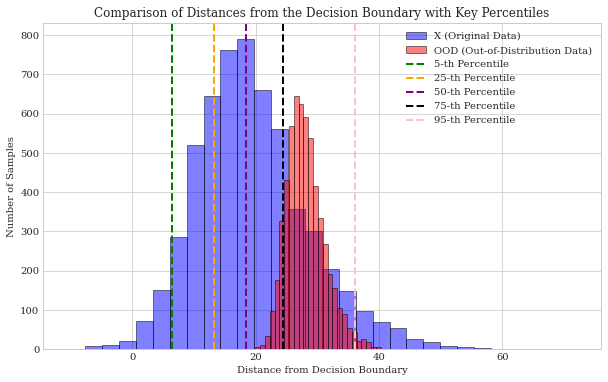

In [79]:
# Step 2: Calculate the distances of the ood points from the decision boundary
c = c_test[:, concept_idx:concept_idx+1]
emb_size = ood_test_embs.shape[-1]//2
ood = c * ood_test_embs[:, concept_idx, :emb_size] + (1 - c) * ood_test_embs[:, concept_idx, emb_size:]

# Step 1: Calculate the distances of the samples in X from the decision boundary
distances_X = log_reg.decision_function(test_embs[:, concept_idx, :emb_size]) - log_reg.decision_function(test_embs[:, concept_idx, emb_size:])  # X is the original high-dimensional dataset
print("Number of original samples in the wrong side of the separator:", np.sum(log_reg.predict_proba(test_embs[:, concept_idx, emb_size:]) < 0.5) + np.sum(log_reg.predict_proba(test_embs[:, concept_idx, :emb_size]) > 0.5))
print("Number of OOD samples in the wrong side of the separator:", np.sum(log_reg.predict_proba(ood_test_embs[:, concept_idx, emb_size:]) < 0.5) + np.sum(log_reg.predict_proba(ood_test_embs[:, concept_idx, :emb_size]) > 0.5))

# Step 2: Calculate the distances of the ood points from the decision boundary
distances_ood = log_reg.decision_function(ood_test_embs[:, concept_idx, :emb_size]) - log_reg.decision_function(ood_test_embs[:, concept_idx, emb_size:])

# Step 3: Calculate key percentiles for the distances in X
percentile_threshs = [5, 25, 50, 75, 95]
percentiles_X = np.percentile(distances_X, percentile_threshs)

# Step 4: Plot the histogram of distances for both X and ood
plt.figure(figsize=(10, 6))

# Plot histogram for X samples
plt.hist(distances_X, bins=30, color='blue', alpha=0.5, label='X (Original Data)', edgecolor='black')

# Plot histogram for ood samples
plt.hist(distances_ood, bins=30, color='red', alpha=0.5, label='OOD (Out-of-Distribution Data)', edgecolor='black')

# Step 5: Plot vertical lines for key percentiles
for percentile, color, thresh in zip(percentiles_X, ['green', 'orange', 'purple', 'black', 'pink'], percentile_threshs):
    plt.axvline(percentile, color=color, linestyle='--', linewidth=2, label=f'{thresh}-th Percentile')

# Step 6: Add titles and labels
plt.title('Comparison of Distances from the Decision Boundary with Key Percentiles')
plt.xlabel('Distance from Decision Boundary')
plt.ylabel('Number of Samples')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [78]:
log_reg.predict_proba(test_embs[:, concept_idx, emb_size:])

array([[9.99999472e-01, 5.27702215e-07],
       [1.00000000e+00, 2.75838202e-10],
       [1.00000000e+00, 7.17768777e-11],
       ...,
       [9.99997036e-01, 2.96375960e-06],
       [9.99991002e-01, 8.99769536e-06],
       [9.99933897e-01, 6.61030805e-05]])

/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/me466/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


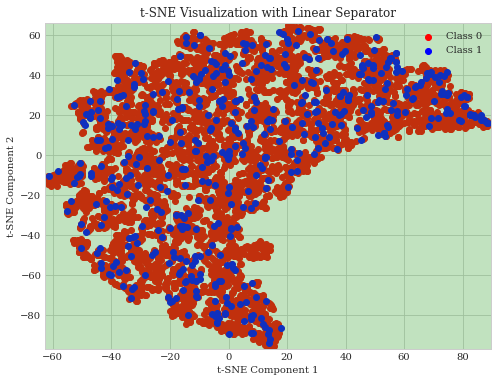

In [43]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

concept_idx = 0
bottleneck = test_bottlenecks[:, concept_idx, :]
ood_bottleneck = ood_test_bottlenecks[:, concept_idx, :]
c = c_test[:, concept_idx]

# Combine bottleneck and ood_bottleneck into one dataset
X = ood_bottleneck

# Apply t-SNE to reduce dimensionality to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Fit a logistic regression model directly on the t-SNE transformed data
log_reg_tsne = LogisticRegression()
log_reg_tsne.fit(X_tsne, c)

# Plot the samples in t-SNE 2D space
plt.figure(figsize=(8, 6))

# Plot samples with label 0
plt.scatter(X_tsne[c == 0, 0], X_tsne[c == 0, 1], color='red', label='Class 0')

# Plot samples with label 1
plt.scatter(X_tsne[c == 1, 0], X_tsne[c == 1, 1], color='blue', label='Class 1')

# Create a meshgrid for plotting the decision boundary
x_min, x_max = X_tsne[:, 0].min() - 1, X_tsne[:, 0].max() + 1
y_min, y_max = X_tsne[:, 1].min() - 1, X_tsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict using the logistic regression model trained on the t-SNE space
Z = log_reg_tsne.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization with Linear Separator')
plt.legend()
plt.show()